In [1]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Particle Generation
#n_1 is the no of particles in an area of radius (del)e
#it can be made faster, layer stacking up
def particles(outer_radius, length, e, n_1):
    
    x = []
    y = []
    z = []
    theta = []
    rad = []
    
    length = int(length)
    
    #no of layers - len_per
    n_l = int(length/e)
    
    #no of circles in a single layer
    n_c_s_l = int(outer_radius/e)
    
    for o in range(n_l):
        z_x = e * o
        for i in range(n_c_s_l):
            radius = e + i * e
            #no of particles per circle
            n_p_c = 6 * (i + 1) - 3 
            del_theta = 2 * np.pi / n_p_c
            for j in range(n_p_c):
                x.append(radius * np.cos(del_theta * (j + 1)))
                y.append(radius * np.sin(del_theta * (j + 1)))
                z.append(z_x) 
                theta.append(del_theta * (j + 1))
                rad.append(radius)
    return x, y, z, theta, rad

   

In [3]:
#Velocity function, forward vel = k1 * (outer_radius ** 2 - radius ** 2), omega = k2 * (outer_radius ** 2 - radius ** 2)
#k1 and k2 are the properties dependent on the flow and wall material
def vel_new_coord(k1, k2, time, length_of_the_box, outer_radius):
    global x
    global y
    global z
    global radius
    global theta
    global burn
    ei = len(z)
    for i in range(ei):
        f_v = k1 * (outer_radius ** 2 - radius[i] ** 2)
        r_v = k2 * (outer_radius ** 2 - radius[i] ** 2)/radius[i]
        x[i] = radius[i] * np.cos(r_v * time + theta[i])
        y[i] = radius[i] * np.sin(r_v * time + theta[i])
        if z[i] > length_of_the_box:
            burn[i] = 0

        z[i] = (z[i] + f_v * time)%length 
        theta[i] = (theta[i] + r_v * time)%(2 * np.pi) 
    return

#Total Velocity
def vel_particles(k1, k2, outer_radius):
    global radius
    v = []
    ei = len(radius)
    for i in range(ei):
        f_v = k1 * (outer_radius ** 2 - radius[i] ** 2)
        r_v = k2 * (outer_radius ** 2 - radius[i] ** 2)/radius[i]
        v.append((f_v ** 2 + r_v ** 2) ** 0.5)
    return v, min(v), max(v)

In [4]:
#BOUNDARY CONDITIONS 
#Adding Temperature Boundary Condition on the face
def temperature_face(t_1):
    global z
    global temperature
    z_min = min(z)
    c = len(z)
    for i in range(c):
        if z[i] == z_min:
            temperature[i] = t_1
    return

#Adding Temperature Boundary Condition on the surface
def temperature_surface(t_1, t_2, outer_radius, length):
    global radius
    global z
    global temperature
    c = len(radius)
    k = (t_2 - t_1)/length
    for i in range(c):
        if radius[i] == outer_radius:
            temperature[i] = k * z[i] + t_1
    return
            

In [5]:
#INITIALIZATION - Adding Initial temperature Conditions

#Will add a semicircular arc 

def initialize_temp(t_3, t_f):
    global temperature
    global radius
    global z
    global vel_min
    global vel_max
    ei = len(z)
    #Temperature condition for the non-lit particles intially
    for i in range(ei):
        if radius[i] != outer_radius:
            temperature[i] = t_3
    
    #Temperature condition for the lit particles - semicircular
    #The flame would be near the center and velocity in a range
    a = (vel_min + vel_max)/4
    b = (vel_min + vel_max) * 3/4
    c = (min(z) + max(z))/4
    d = (max(z) + min(z)) * 3/4
    for i in range(ei):
        if vel[i] <= b and vel[i] >= a and z[i] >= c and z[i] <= d:
            if theta[i] <= 1.5 * np.pi and theta[i] >= 0.25 * np.pi:
                temperature[i] = t_f
    
    return
    
 

In [6]:
#HEAT CIRCULATION
#KEEP LENGTH/DEL_E >= 10
def heat_circulation(t_tran, t_f, outer_radius):
    global temperature
    global radius
    global z
    global burn
    global del_e
    ei = len(z)
    temp = np.copy(temperature)
    del_theta = 2/5 * np.pi
    
    """
    #CODE FOR SPACE PARTITIONING
    avg_length = 2 * del_e
    bin_length = 5 * del_e
    space_partition = []
    n_del_e = int(length/del_e)
    no_of_bins = int(np.ceil((length - (avg_length + del_e))/(bin_length - (avg_length + del_e))))
    #print(no_of_bins)
    assert(no_of_bins > 0), "No of partitions is zero!"
    
    for i1 in range(no_of_bins):
        a_part = []
        a11 = i1 * del_e
        a12 = (i1 + bin_length) * del_e 
        for i2 in range(ei):
            if i1 != (no_of_bins - 1):
                if z[i2]>= a11 and z[i2] <= a12:
                    a_part.append(i2)
                    #print(i2)
            else:
                if z[i2] >= a11:
                    a_part.append(i2)
                    #print(i2)
        space_partition.append(a_part)
    
    assert(len(space_partition) > 0), "Partitioned array has no elememt!"
    #print(type(space_partition[0][1]))
    
    
    for i in range(ei):
        k_d = np.floor(z[i]/del_e) * del_e
        distance = []
        if radius[i] != outer_radius:                  
            if k_d > bin_length:
                bin_temp = np.floor((np.floor((k_d - bin_length)/(bin_length - (avg_length + del_e)))/(bin_length - (avg_length + del_e))))
                if ((bin_length + bin_temp * (bin_length - (avg_length + del_e))) - z[i]) < avg_length:
                    bin_temp = bin_temp + 1
            if k_d <= bin_length:
                bin_temp = 0
                if ((bin_length + bin_temp * (bin_length - (avg_length + del_e))) - z[i]) < avg_length:
                    bin_temp = bin_temp + 1
            
            if bin_temp == (no_of_bins):
                bin_temp = bin_temp - 1
             
            assert(bin_temp>=0), "Bin index is negative!"
            assert(bin_temp<=len(space_partition)), "Bin index is greater than the length of space partition!"
            
            print(len(space_partition[0]), space_partition[0][0])
            
            cdk = len(space_partition[bin_temp])
            for j1 in range(cdk):                     
                j = (space_partition[bin_temp][j1])
                print(j)
                if abs(radius[i] - radius[j]) <= 1.5 * del_e and abs(theta[i] - theta[j]) <= (del_theta):
                    distance.append((((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2 + (z[i] - z[j]) ** 2) ** 0.5, j))
                                     
            distance = sorted(distance, key = lambda val: val[0])
            
            assert(len(distance) >= 3), "Length of distance matrix is less than 3!"
            temp[i] = (temperature[distance[0][1]] + temperature[distance[1][1]] + temperature[distance[2][1]])/3
            
            if temp[i] >= t_tran and burn[i] == 0:
                temp[i] = t_f
                burn[i] = 1
            
    """
    a = (vel_min + vel_max)/4
    b = (vel_min + vel_max) * 3/4
    
    for i in range(ei):
        distance = []
        if radius[i] != outer_radius:
            for j in range(ei):
                if abs(z[i] - z[j]) <= del_e and abs(radius[i] - radius[j]) <= del_e and abs(theta[i] - theta[j]) <= (del_theta):
                    distance.append((((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2 + (z[i] - z[j]) ** 2) ** 0.5, j))
                #print(distance[j])
            distance = sorted(distance, key = lambda val: val[0])
            assert(len(distance) >= 4), "Length of distance matrix is less than 4!"
            temp[i] = (temperature[distance[0][1]] + temperature[distance[1][1]] + temperature[distance[2][1]] + temperature[distance[3][1]])/4
            if temp[i] >= t_tran and burn[i] == 0 and vel[i] <= b and vel[i] >= a :
                temp[i] = t_f
                burn[i] = 1
    #for i in range(ei):
     #   print(temp[i] - temperature[i])
    
    return temp

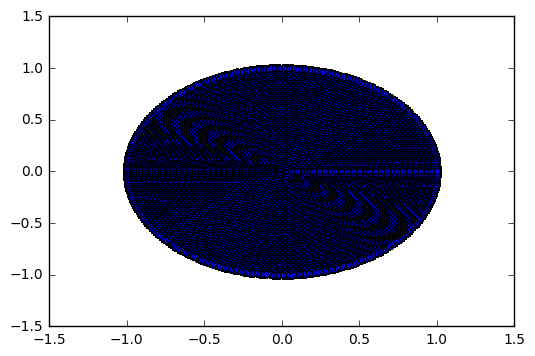

In [ ]:
burn = []
x = 0
y = 0
z = 0
vel = 0
vel_min = 0
vel_max = 0
theta = 0
radius = 0
length = 2
outer_radius = 1
k1 = 0.1
k2 = 1
t_f = 1000
t_3 = 273
t_tran = 320
t_1 = 273
t_2 = 400
del_e = 0.02
starter_n = 3
time_step = 0.1
#Creating the particles
x, y, z, theta, radius = particles(outer_radius, length, del_e, starter_n)
vel, vel_min, vel_max = vel_particles(k1, k2, outer_radius)
#print(vel_min, vel_max)

#Adding the temperature profile
for i in range(len(z)):
    burn.append(0) 

temperature = np.copy(z)
temperature_face(t_1)
temperature_surface(t_1, t_2, outer_radius, length)
initialize_temp(t_3, t_f)
plt.scatter(x, y)

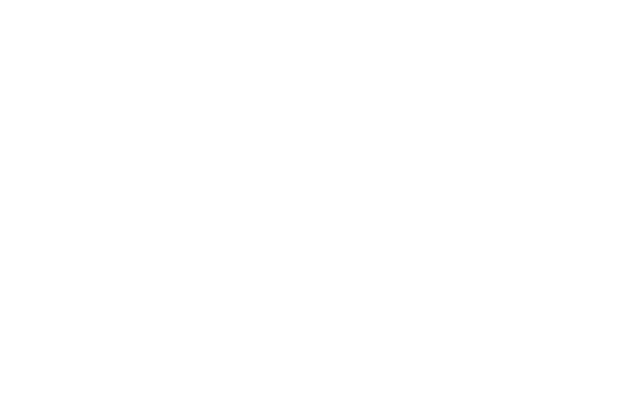

In [ ]:
#Animations
grid_size = 1
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')
ax.set_xlim((-grid_size, grid_size))
ax.set_ylim((-grid_size, grid_size))
ax.set_zlim((0, length + 1))

line1, = ax.plot([], [], [], 'bo')

def init():
    line1.set_data([], [])
    line1.set_3d_properties([])    
    return line1,

def animate(i):
    global temperature
    """
    global fx
    global fy
    global fz
    """
    fx = []
    fy = []
    fz = []
    for i in range(len(z)):
        if temperature[i] >= 800 and radius[i] != outer_radius:
            fx.append(x[i])
            fy.append(y[i])
            fz.append(z[i])
    line1.set_data(fx, fy)
    line1.set_3d_properties(fz) 
    ax.view_init(2*i+60, 3 * i)
    fig.canvas.draw()
    
    vel_new_coord(k1, k2, time_step, length, outer_radius) 
    for i in range(5):
        temperature_face(t_1)
        temperature = heat_circulation(t_tran, t_f, outer_radius)
        
    return line1,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,init_func = init, frames = 100, interval = 500 , blit=True)
plt.show()
HTML(anim.to_html5_video())


In [ ]:
print(int(1))